# Tracking
First we import the necessary tools:

In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import scipy

plt.gray()

<Figure size 432x288 with 0 Axes>

Create the stereo class to change any image from 2D to 3D

In [19]:
class Stereo ():
    """
    Class that calculates the disparity of a stereo camera and keeps it so 
    any wanted image can be transformed to 3D. 
    """
    def __init__(self, leftFilename, rightFilename):
        """
        Method to instantiate the class.
            * Input:
            - 
        """
        self.leftFilename = leftFilename
        self.rightFilename = rightFilename
        self.disp = 0
        self.calculateDisparity()
    
    def calculateDisparity (self):
        # Get the images
        leftImg = cv2.imread(leftFilename)
        rightImg = cv2.imread(rightFilename)
        
        # Get the right color
#         leftImg = cv2.cvtColor(leftImg, cv2.COLOR_RGB2BGR)
#         rightImg = cv2.cvtColor(rightImg, cv2.COLOR_RGB2BGR)
        
        # Resize images
        imgSize = (int(leftImg.shape[1]/5), int(leftImg.shape[0]/5))
        leftImg = cv2.resize(leftImg, imgSize, interpolation=cv2.INTER_AREA)
        rightImg = cv2.resize(rightImg, imgSize, interpolation=cv2.INTER_AREA)
        
        # Convert images to grayscale for template matching
        leftGray = cv2.cvtColor(leftImg, cv2.COLOR_BGR2GRAY)
        rightGray = cv2.cvtColor(rightImg, cv2.COLOR_BGR2GRAY)
        
        # Plot
        f, (axLeft, axRight) = plt.subplots(1, 2, figsize=(18,18))
        axLeft.imshow(leftGray)
        axRight.imshow(rightGray)
        
        # Define parameters
        minDisp = 20
        numDisp = 3 * 16
        blockSize = 5
        stereo = cv2.StereoBM_create(numDisparities=numDisp, blockSize = blockSize)
        stereo.setMinDisparity(minDisp)
        stereo.setDisp12MaxDiff(200)
        stereo.setUniquenessRatio(1)
        stereo.setSpeckleRange(3)
        stereo.setSpeckleWindowSize(3)
        
        disp = stereo.compute(leftGray, rightGray).astype(np.float32) / 16.0
        
        plt.figure(figsize=(18, 18))
        plt.imshow(disp)
        
    
    def get3DImg(self):
        pass

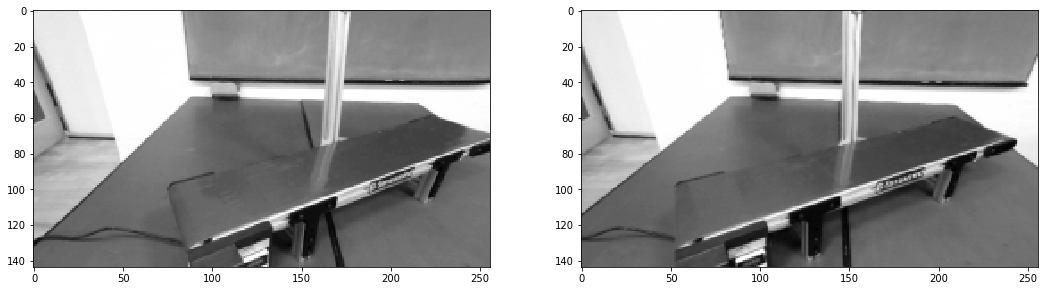

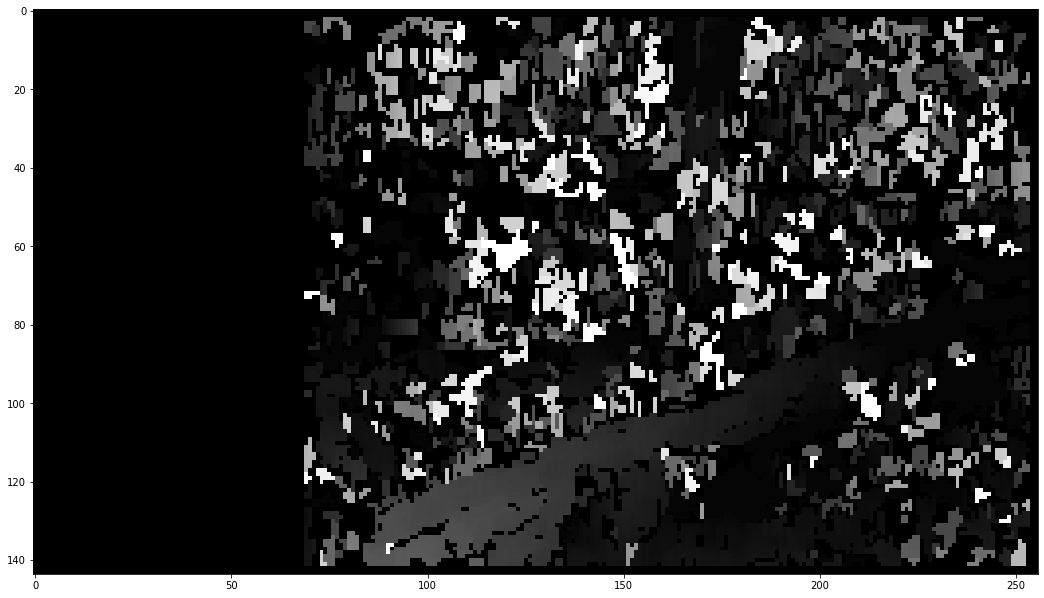

In [20]:
# Read the images in this directory
rightFilename = "undistortedImagesWithoutOcclusion/1585434279_805531979_Right.png"
leftFilename = rightFilename.replace("Right", "Left")
rightImagesGlob = glob.glob("undistortedImagesWithoutOcclusion/*Right.png")
assert rightImagesGlob


stereoCamera = Stereo(leftFilename, rightFilename)


# for rightFilename in rightImagesGlob:
#     # Get the left image from the right image
#     leftFilename = rightFilename.replace("Right", "Left")
#     rightImg = cv2.imread(rightFilename)
#     leftImg = cv2.imread(leftFilename)
# #     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)